In [111]:
import pandas as pd
import numpy as np
import os
from shutil import copyfile, move
import random

## Data Preparation Script

In [112]:
'''
UPDATE:
basedir needs to be changed when collecting folders/files from a different directory.
'''

basedir = '/Users/nathenhuang/Documents/Personal/Courses/GMU/OR 610 - Deep Learning/Homework/Final Project/Data/plantvillage dataset/color'

## List all folders in the color images folder
os.listdir(basedir)

['Strawberry___healthy',
 'Grape___Black_rot',
 'Potato___Early_blight',
 'Blueberry___healthy',
 'Corn_(maize)___healthy',
 'Tomato___Target_Spot',
 'Peach___healthy',
 'Potato___Late_blight',
 'Tomato___Late_blight',
 'Tomato___Tomato_mosaic_virus',
 'Pepper,_bell___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Tomato___Leaf_Mold',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Cherry_(including_sour)___Powdery_mildew',
 'Apple___Cedar_apple_rust',
 'Tomato___Bacterial_spot',
 'Grape___healthy',
 'Tomato___Early_blight',
 'Corn_(maize)___Common_rust_',
 'Grape___Esca_(Black_Measles)',
 'Raspberry___healthy',
 'Tomato___healthy',
 'Cherry_(including_sour)___healthy',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Apple___Apple_scab',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Peach___Bacterial_spot',
 'Pepper,_bell___Bacterial_spot',
 'Tomato___Septoria_leaf_spot',
 'Squash___Powdery_mildew',
 'Corn_(maize)___Cercospora_leaf_

#### Create a central directory ('all_data_(augmentation type)') for all images pulled from out of their folders so that they are easier to use later

In [113]:
## Create a list of file and folder name across all folders for all images in the color folder
images = []

for i, j in enumerate(os.listdir(basedir)):
    for m in os.listdir(os.path.join(basedir,j)):
        images.append([m,j])

##### Create a reference data table from which you will later split the images into train/val

In [114]:
## Convert the images list to a data frame

df = pd.DataFrame(images, columns=['File', 'Folder'])

In [115]:
## Create new columns out of the folder name: 
## - Plant (for the name of the plant) and 
## - Status (for healthy or whichever condition the plant leaf has)

df_ = df.Folder.str.split('___', expand=True)
df['Plant'] = df_[0].astype('category')
df['Status'] = df_[1]

In [117]:
## Create a new folder called 'all_data' to store all of the images in one place

if not os.path.exists(os.path.join(os.path.dirname(basedir), 'all_data_color')):
    os.mkdir(os.path.join(os.path.dirname(basedir), 'all_data_color'))

## Copy each file from each folder into the all_data_color folder

for i, j in enumerate(os.listdir(basedir)):
    for m in os.listdir(os.path.join(basedir,j)):
        copyfile(os.path.join(basedir,j,m), os.path.join(os.path.dirname(basedir), 'all_data_color', m))

In [122]:
## Create Folders for each of the Plant_Statuses
folders = np.unique(np.array(df.Folder))

# plant_labels = np.array(df.Plant)
# status_labels = np.array(df.Status)

In [124]:
## Split the dataframe with files into training/test sets
random.seed(1112)
msk = np.random.rand(len(df)) < 0.8

train = df[msk]
test = df[~msk]

In [125]:
## Convert the dataframes into Series

train_img = train.File.tolist()
train_labels = train.Plant.tolist()

test_img = test.File.tolist()
test_labels = test.Plant.tolist()

#### Create train/val folders for the current image type

In [129]:
'''
UPDATE:
current_data_folder is the name of the folder you will be moving all of your labeled train/val folder-images into in order to 
perform the transfer learning in the next part of the code

--> Make sure to update current_data_folder to where your files need to be stored
'''

## Create folders in the All Data Folder for training and validation (test)
## This creates de-facto train/validation sets for running the transfer learning approach
current_data_folder = 'color_train_val'

os.mkdir(os.path.join('/Users/nathenhuang/Documents/Personal/Courses/GMU/OR 610 - Deep Learning/Homework/Final Project/Data/plantvillage dataset/', current_data_folder))
os.mkdir(os.path.join('/Users/nathenhuang/Documents/Personal/Courses/GMU/OR 610 - Deep Learning/Homework/Final Project/Data/plantvillage dataset/', current_data_folder, 'train'))
os.mkdir(os.path.join('/Users/nathenhuang/Documents/Personal/Courses/GMU/OR 610 - Deep Learning/Homework/Final Project/Data/plantvillage dataset/', current_data_folder, 'val'))

FileExistsError: [Errno 17] File exists: '/Users/nathenhuang/Documents/Personal/Courses/GMU/OR 610 - Deep Learning/Homework/Final Project/Data/plantvillage dataset/color_train_val'

#### Move files from the all files folder into train/val folders with corresponding label folders

In [133]:
'''
UPDATE:
data_dir is the name of the folder you will be moving all of your labeled train/val folder-images into in order to 
perform the transfer learning in the next part of the code

--> Make sure to update data_dir to where your files need to be stored
'''

data_dir = os.path.join(basedir, '..', current_data_folder)

## Move files currently in All Data folder to train/val folders based on the lists of train/test files 
for i in range(len(df)):
    if df['File'][i] in train_img: 
        plant_dir = os.path.join(data_dir, 'train', df['Folder'][i])
        
        if not os.path.exists(plant_dir):
            os.mkdir(plant_dir)
        
        copyfile(os.path.join(os.path.dirname(basedir), 'all_data_color', df['File'][i]), os.path.join(plant_dir, df['File'][i]))
    
    elif df['File'][i] in test_img:
        plant_dir = os.path.join(data_dir, 'val', df['Folder'][i])
                 
        if not os.path.exists(plant_dir):
            os.mkdir(plant_dir)
            
        copyfile(os.path.join(os.path.dirname(basedir), 'all_data_color', df['File'][i]), os.path.join(plant_dir, df['File'][i])) 
    
    else:
        next

## Transfer Learning
Tutorial via: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [47]:
## Import necessary libraries

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [135]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/Users/nathenhuang/Documents/Personal/Courses/GMU/OR 610 - Deep Learning/Homework/Final Project/Data/plantvillage dataset/color_train_val'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

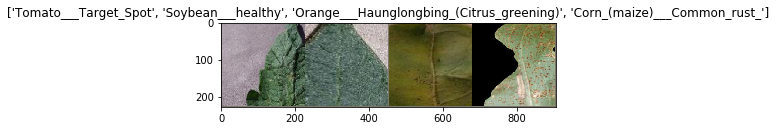

In [140]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [141]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [142]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## AlexNet

In [144]:
torchvision.models.alexnet(pretrained=True)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [168]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_conv = torchvision.models.alexnet(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
# num_ftrs = model_conv.fc.in_features
num_ftrs = model_conv.classifier[6].in_features
# model_conv.fc = nn.Linear(num_ftrs, len(class_names))
model_conv.classifier[6] = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
# optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
optimizer_conv = optim.SGD(model_conv.classifier[6].parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=2, gamma=0.1)

In [169]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 1.6496 Acc: 0.7008
val Loss: 1.0074 Acc: 0.8518

Epoch 1/4
----------
train Loss: 1.5383 Acc: 0.7550
val Loss: 0.7688 Acc: 0.8872

Epoch 2/4
----------
train Loss: 0.9115 Acc: 0.8208
val Loss: 0.4868 Acc: 0.9121

Epoch 3/4
----------
train Loss: 0.7822 Acc: 0.8344
val Loss: 0.4063 Acc: 0.9146

Epoch 4/4
----------
train Loss: 0.7233 Acc: 0.8360
val Loss: 0.3815 Acc: 0.9173

Training complete in 167m 14s
Best val Acc: 0.917312


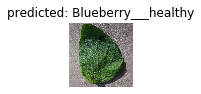

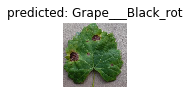

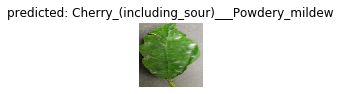

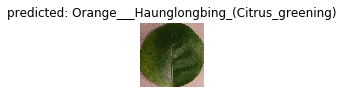

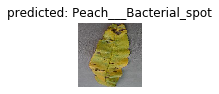

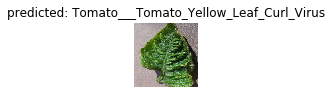

In [170]:
visualize_model(model_conv)

## DenseNet

In [165]:
torchvision.models.densenet161(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /Users/nathenhuang/.cache/torch/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:05<00:00, 19.8MB/s] 


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [171]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_conv = torchvision.models.densenet161(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier.in_features
model_conv.classifier = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=2, gamma=0.1)

In [172]:
## This took 56 hours to train on a cpu lol

dense_model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 1.0520 Acc: 0.7156
val Loss: 0.2736 Acc: 0.9172

Epoch 1/4
----------
train Loss: 0.6755 Acc: 0.8027
val Loss: 0.2172 Acc: 0.9300

Epoch 2/4
----------
train Loss: 0.5579 Acc: 0.8372
val Loss: 0.1869 Acc: 0.9427

Epoch 3/4
----------
train Loss: 0.5554 Acc: 0.8389
val Loss: 0.1643 Acc: 0.9476

Epoch 4/4
----------
train Loss: 0.5375 Acc: 0.8463
val Loss: 0.1571 Acc: 0.9503

Training complete in 3394m 56s
Best val Acc: 0.950313
